# Distributions of all the events in the dataset

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os

sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append('/home/fcufino/ETH_faser/Utils')

from Utils.plot import *
from Utils.extract_features_all_ev import *
from Utils.ID_events import *

In [2]:
folder_path = "/scratch3/salonso/faser/events_v3.5"  
output_folder = "."

os.makedirs(output_folder, exist_ok=True)

In [3]:
# Define variables to extract (including is_cc and in_neutrino_pdg for filtering)
variables_to_extract = ['is_cc', 'in_neutrino_pdg', 
                        'e_vis', 'sp_momentum', 'vis_sp_momentum', 'jet_momentum', 'pt_miss',
                        'in_neutrino_momentum', 'in_neutrino_energy',
                        'out_lepton_momentum', 'out_lepton_energy',
                        'rear_cal_energy', 'rear_hcal_energy', 'rear_mucal_energy','faser_cal_energy']

In [4]:
output_folder = "."

In [5]:
features_to_load = ["run_number", "event_id", "is_cc", "in_neutrino_pdg", "out_lepton_pdg"]

# Load data
data_filter = load_variables_from_npz(folder_path, features_to_load)


Processing files: 100%|██████████| 144939/144939 [00:12<00:00, 11672.07it/s]


In [6]:
type(data_filter['event_id'])

numpy.ndarray

In [7]:
# Apply the correct conditions directly without np.array conversion
dict_nu_e = {
    "run_number": data_filter["run_number"][(data_filter["is_cc"] == 1) & 
                                            ((data_filter["in_neutrino_pdg"] == 12) | (data_filter["in_neutrino_pdg"] == -12))],
    "event_id": data_filter["event_id"][(data_filter["is_cc"] == 1) & 
                                        ((data_filter["in_neutrino_pdg"] == 12) | (data_filter["in_neutrino_pdg"] == -12))],
}

dict_nu_mu = {
    "run_number": data_filter["run_number"][(data_filter["is_cc"] == 1) & 
                                            ((data_filter["in_neutrino_pdg"] == 14) | (data_filter["in_neutrino_pdg"] == -14))],
    "event_id": data_filter["event_id"][(data_filter["is_cc"] == 1) & 
                                        ((data_filter["in_neutrino_pdg"] == 14) | (data_filter["in_neutrino_pdg"] == -14))],
}

dict_nu_tau = {
    "run_number": data_filter["run_number"][(data_filter["is_cc"] == 1) & 
                                            ((data_filter["in_neutrino_pdg"] == 16) | (data_filter["in_neutrino_pdg"] == -16))],
    "event_id": data_filter["event_id"][(data_filter["is_cc"] == 1) & 
                                        ((data_filter["in_neutrino_pdg"] == 16) | (data_filter["in_neutrino_pdg"] == -16))],
}

# Filter for Neutral Current (NC) interactions where is_cc != 1 (i.e., NC interaction)
dict_nc = {
    "run_number": data_filter["run_number"][data_filter["is_cc"] == 0],
    "event_id": data_filter["event_id"][data_filter["is_cc"] == 0],
}

# Print the number of events in the original filtered data
print("Number of events in the dictionary: ", len(data_filter["run_number"]))
print("Number of events in the nu_e dictionary: ", len(dict_nu_e["run_number"]))
print("Number of events in the nu_mu dictionary: ", len(dict_nu_mu["run_number"]))
print("Number of events in the nu_tau dictionary: ", len(dict_nu_tau["run_number"]))
print("Number of events in the NC dictionary: ", len(dict_nc["run_number"]))


Number of events in the dictionary:  144939
Number of events in the nu_e dictionary:  18218
Number of events in the nu_mu dictionary:  89087
Number of events in the nu_tau dictionary:  473
Number of events in the NC dictionary:  37161


In [8]:
file_names_nc = [os.path.join(folder_path, "{}_{}.npz".format(int(run_number), int(event_id))) for run_number, event_id in zip(dict_nc["run_number"], dict_nc["event_id"])]
file_names_nu_e = [os.path.join(folder_path, "{}_{}.npz".format(int(run_number), int(event_id))) for run_number, event_id in zip(dict_nu_e["run_number"], dict_nu_e["event_id"])]
file_names_nu_mu = [os.path.join(folder_path, "{}_{}.npz".format(int(run_number), int(event_id))) for run_number, event_id in zip(dict_nu_mu["run_number"], dict_nu_mu["event_id"])]
file_names_nu_tau = [os.path.join(folder_path, "{}_{}.npz".format(int(run_number), int(event_id))) for run_number, event_id in zip(dict_nu_tau["run_number"], dict_nu_tau["event_id"])]

In [9]:
# data_nc     = load_variables_from_npz(folder_path, variables_to_extract, num_workers=28, file_selected=file_names_nc)
# data_nu_e   = load_variables_from_npz(folder_path, variables_to_extract, num_workers=28, file_selected=file_names_nu_e)
# data_nu_mu  = load_variables_from_npz(folder_path, variables_to_extract, num_workers=28, file_selected=file_names_nu_mu)
# data_nu_tau = load_variables_from_npz(folder_path, variables_to_extract, num_workers=28, file_selected=file_names_nu_tau)

In [10]:
# #save data in 4 files .npz
# np.savez(f"{output_folder}/nu_e.npz", **data_nu_e)
# np.savez(f"{output_folder}/nu_mu.npz", **data_nu_mu)
# np.savez(f"{output_folder}/nu_tau.npz", **data_nu_tau)
# np.savez(f"{output_folder}/nc.npz", **data_nc)

# print("Data saved in .npz files")

In [11]:
#load data from .npz files
data_nu_e = np.load(f"{output_folder}/nu_e.npz")
data_nu_mu = np.load(f"{output_folder}/nu_mu.npz")
data_nu_tau = np.load(f"{output_folder}/nu_tau.npz")
data_nc = np.load(f"{output_folder}/nc.npz")

In [12]:
for key in data_nu_e.keys():
    print(key, data_nu_e[key].shape)

is_cc (24468,)
in_neutrino_pdg (24468,)
e_vis (24468,)
sp_momentum (24468, 3)
vis_sp_momentum (24468, 3)
jet_momentum (24468, 3)
pt_miss (24468,)
in_neutrino_momentum (24468, 3)
in_neutrino_energy (24468,)
out_lepton_momentum (24468, 3)
out_lepton_energy (24468,)
rear_cal_energy (24468,)
rear_hcal_energy (24468,)
rear_mucal_energy (24468,)
faser_cal_energy (24468,)


## Distribution Plot

In [13]:
feat_plot = ["e_vis", "sp_momentum", "vis_sp_momentum", "jet_momentum", "pt_miss", "in_neutrino_momentum", "in_neutrino_energy", "out_lepton_momentum", "out_lepton_energy", "rear_cal_energy", "rear_hcal_energy", "rear_mucal_energy", "faser_cal_energy"]

In [14]:
plt.style.use('ggplot')

In [15]:
# import matplotlib.pyplot as plt

# # Reset all Matplotlib settings to their default values
# plt.rcdefaults()

# # Now, you can proceed with your plotting as usual


In [16]:
configure_matplotlib()

KeyError: 'hist.edgecolor is not a valid rc parameter (see rcParams.keys() for a list of valid parameters)'

In [ ]:
import matplotlib.pyplot as plt

def plot_histograms(data_nu_e, data_nu_mu, data_nu_tau, data_nc, variable_name, bins=30, figsize=(20, 5)):
    """
    Plots histograms of the specified variable for different datasets with purple color.
    """
    # RGB color for purple normalized to [0, 1] range
    purple_color = (190/255, 180/255, 211/255)  # RGB for purple

    # Check size of data, if 1d, do directly the histogram
    if data_nu_e[variable_name].ndim == 1:     
        # Create a figure with 1 row and 4 columns of subplots
        fig, axes = plt.subplots(1, 4, figsize=figsize)

        # Plot the histograms in the respective subplots
        axes[0].hist(data_nu_e[variable_name], bins=bins, alpha=0.7, color=purple_color)
        axes[0].set_title('nu_e')
        axes[0].set_xlabel(f'{variable_name}')
        axes[0].set_ylabel('Frequency')

        axes[1].hist(data_nu_mu[variable_name], bins=bins, alpha=0.7, color=purple_color)
        axes[1].set_title('nu_mu')
        axes[1].set_xlabel(f'{variable_name}')
        axes[1].set_ylabel('Frequency')

        axes[2].hist(data_nu_tau[variable_name], bins=bins, alpha=0.7, color=purple_color)
        axes[2].set_title('nu_tau')
        axes[2].set_xlabel(f'{variable_name}')
        axes[2].set_ylabel('Frequency')

        axes[3].hist(data_nc[variable_name], bins=bins, alpha=0.7, color=purple_color)
        axes[3].set_title('NC')
        axes[3].set_xlabel(f'{variable_name}')
        axes[3].set_ylabel('Frequency')

        # Adjust the layout to prevent overlap
        plt.tight_layout()

        # Show the plot
        plt.show()
    else:
        # If multi-dimensional, plot a histogram per each dimension
        for i in range(data_nu_e[variable_name].shape[1]):
            fig, axes = plt.subplots(1, 4, figsize=figsize)

            # Plot the histograms in the respective subplots
            axes[0].hist(data_nu_e[variable_name][:, i], bins=bins, alpha=0.7, color=purple_color)
            axes[0].set_title('nu_e')
            axes[0].set_xlabel(f'{variable_name}_{i}')
            axes[0].set_ylabel('Frequency')

            axes[1].hist(data_nu_mu[variable_name][:, i], bins=bins, alpha=0.7, color=purple_color)
            axes[1].set_title('nu_mu')
            axes[1].set_xlabel(f'{variable_name}_{i}')
            axes[1].set_ylabel('Frequency')

            axes[2].hist(data_nu_tau[variable_name][:, i], bins=bins, alpha=0.7, color=purple_color)
            axes[2].set_title('nu_tau')
            axes[2].set_xlabel(f'{variable_name}_{i}')
            axes[2].set_ylabel('Frequency')

            axes[3].hist(data_nc[variable_name][:, i], bins=bins, alpha=0.7, color=purple_color)
            axes[3].set_title('NC')
            axes[3].set_xlabel(f'{variable_name}_{i}')
            axes[3].set_ylabel('Frequency')

            # Adjust the layout to prevent overlap
            plt.tight_layout()

            # Show the plot
            plt.show()


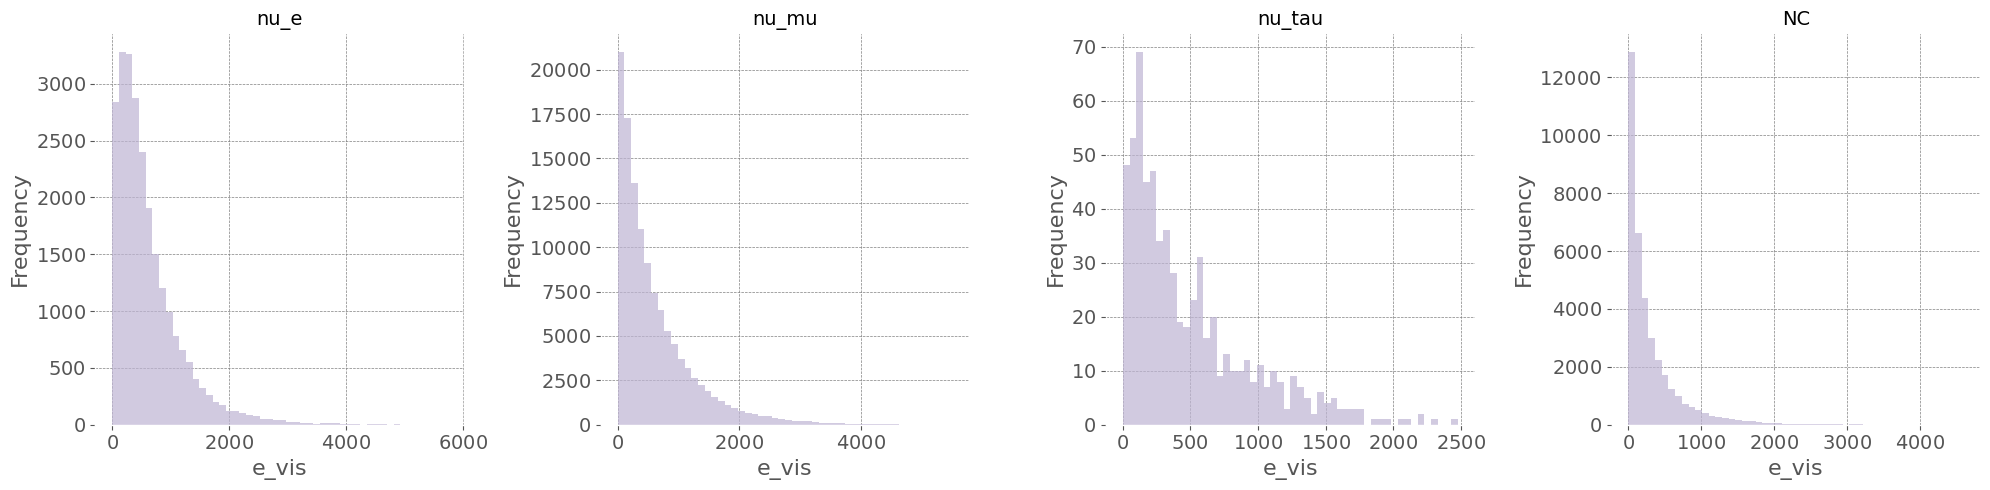

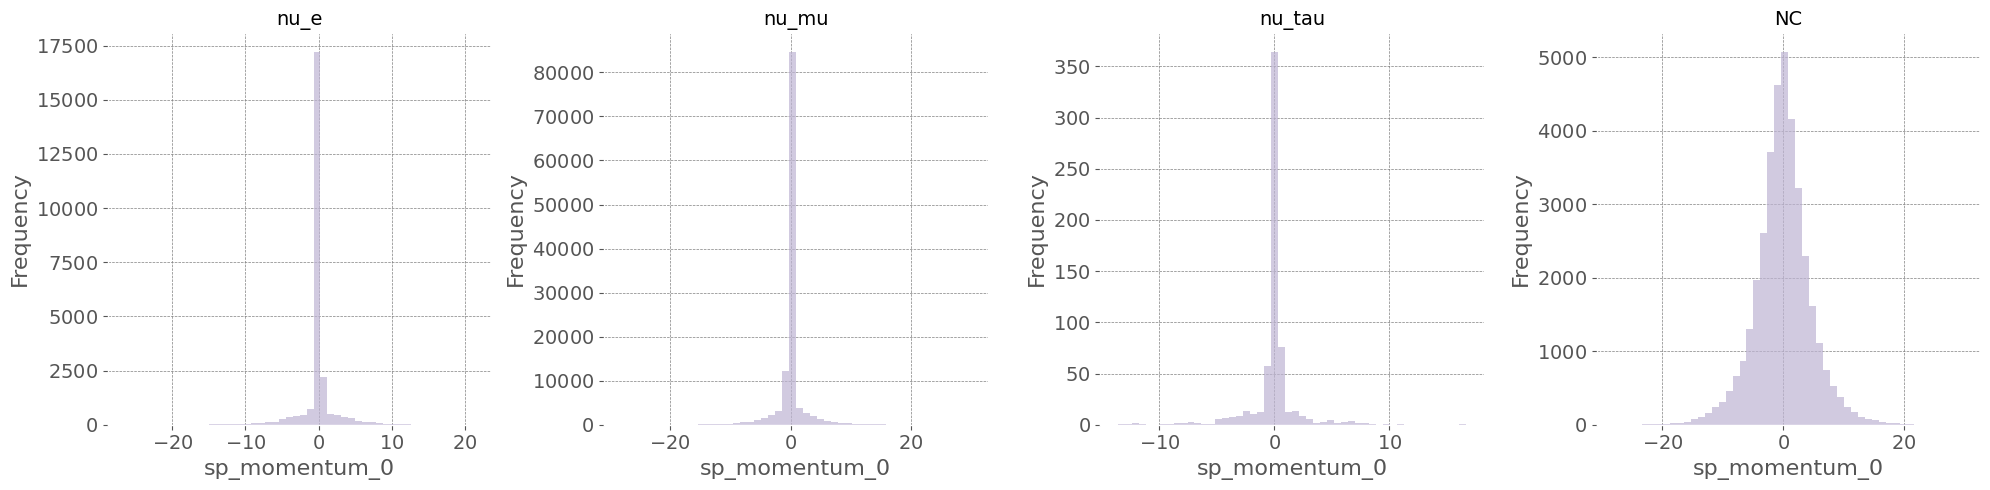

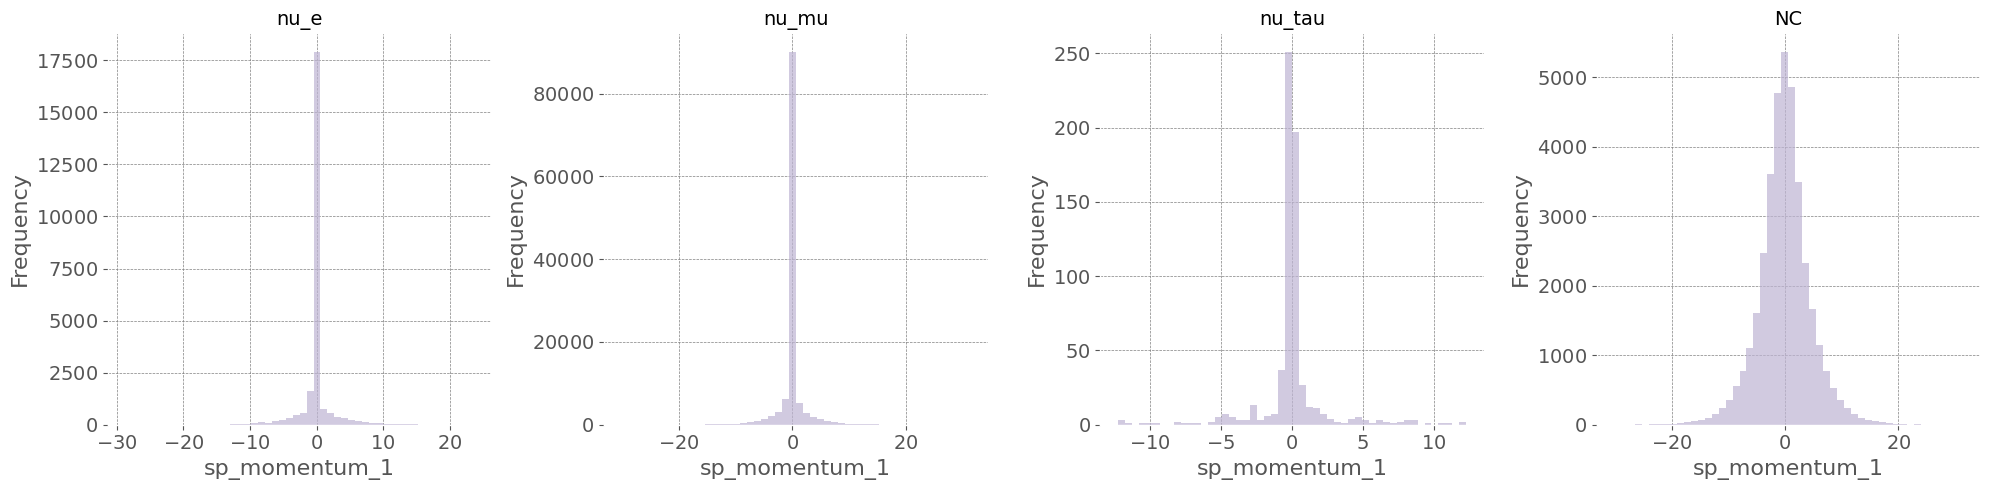

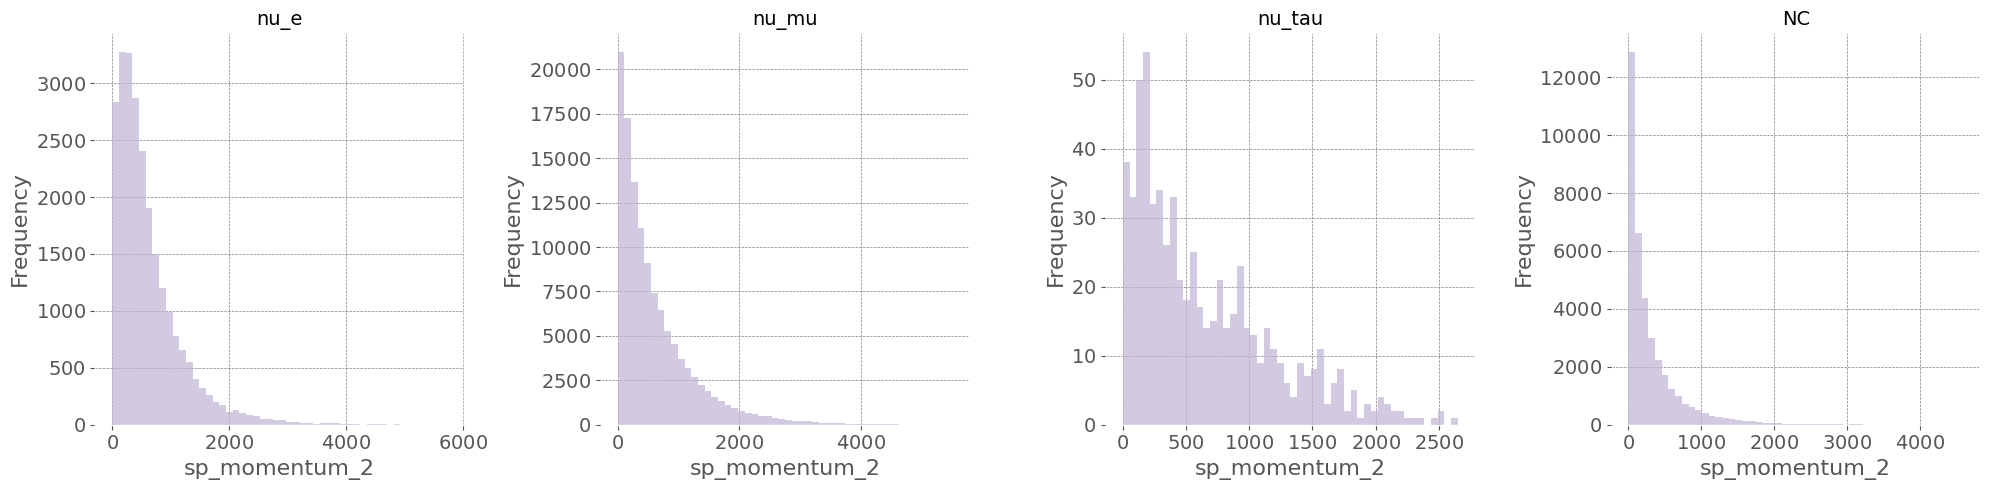

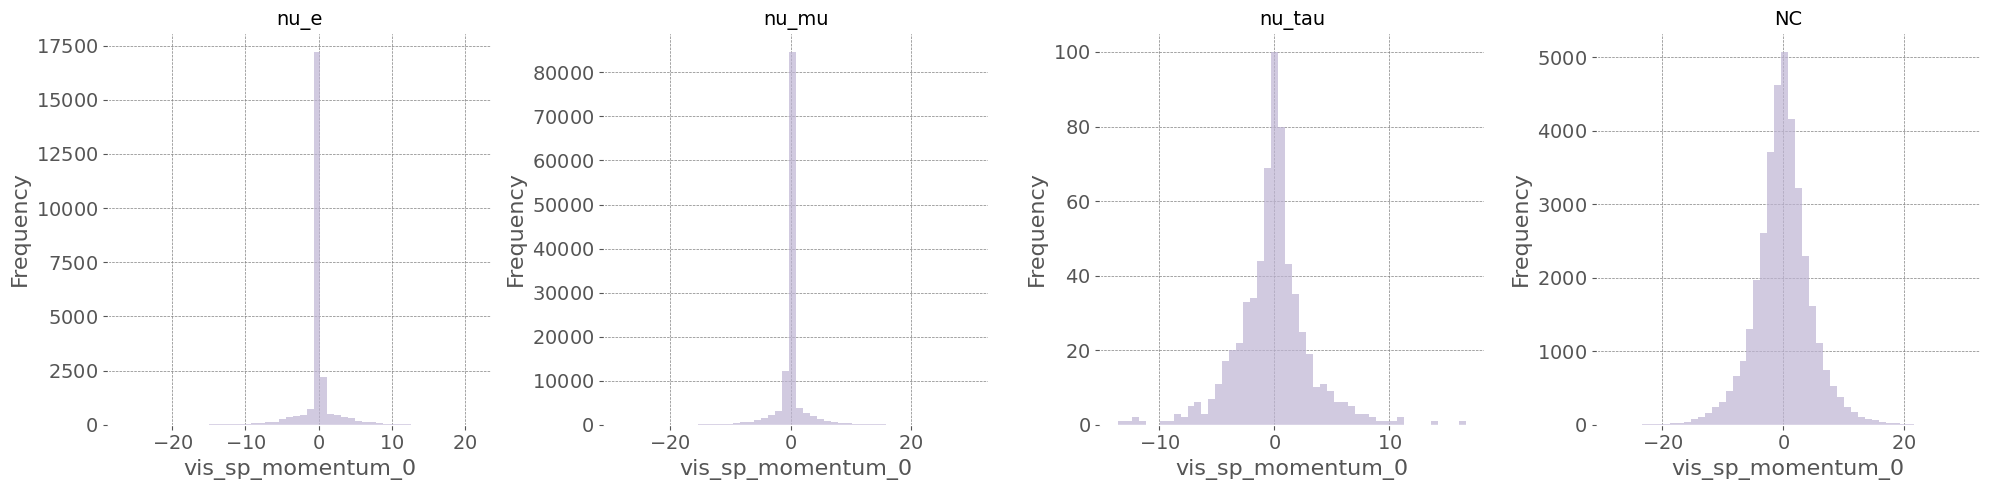

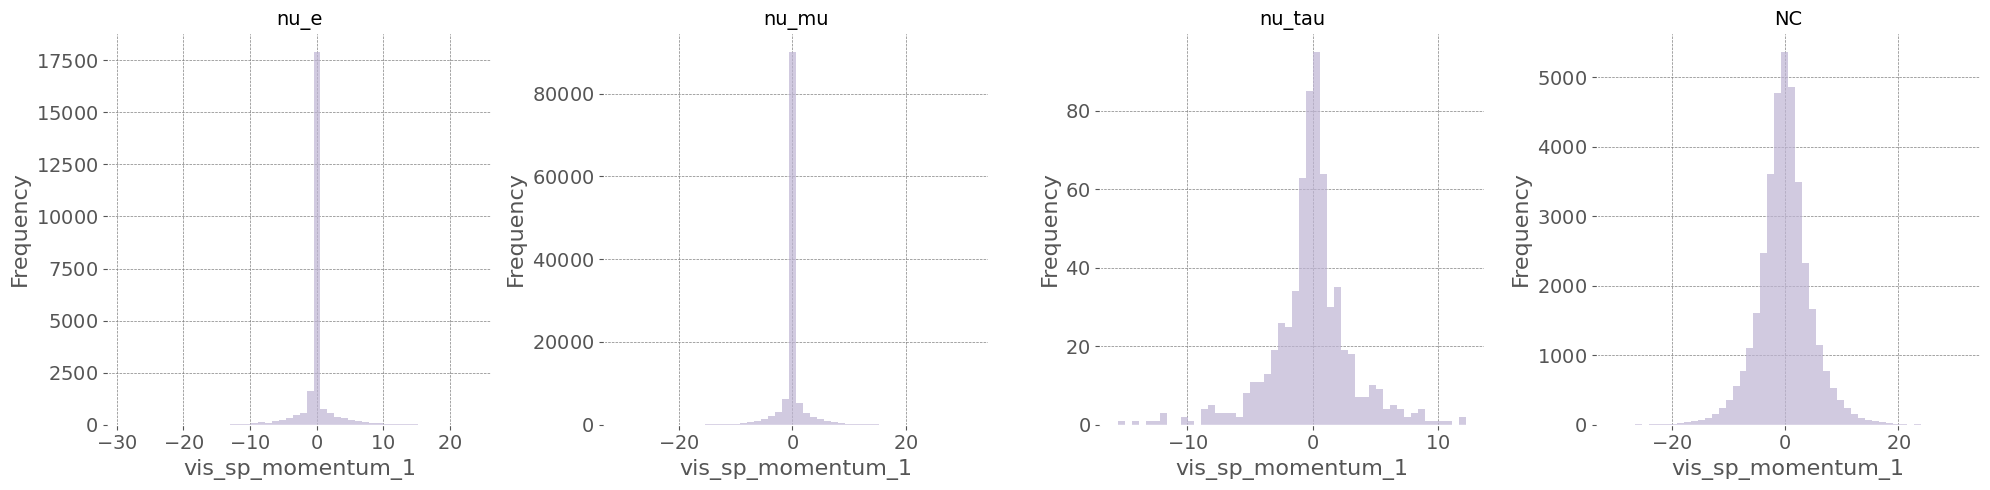

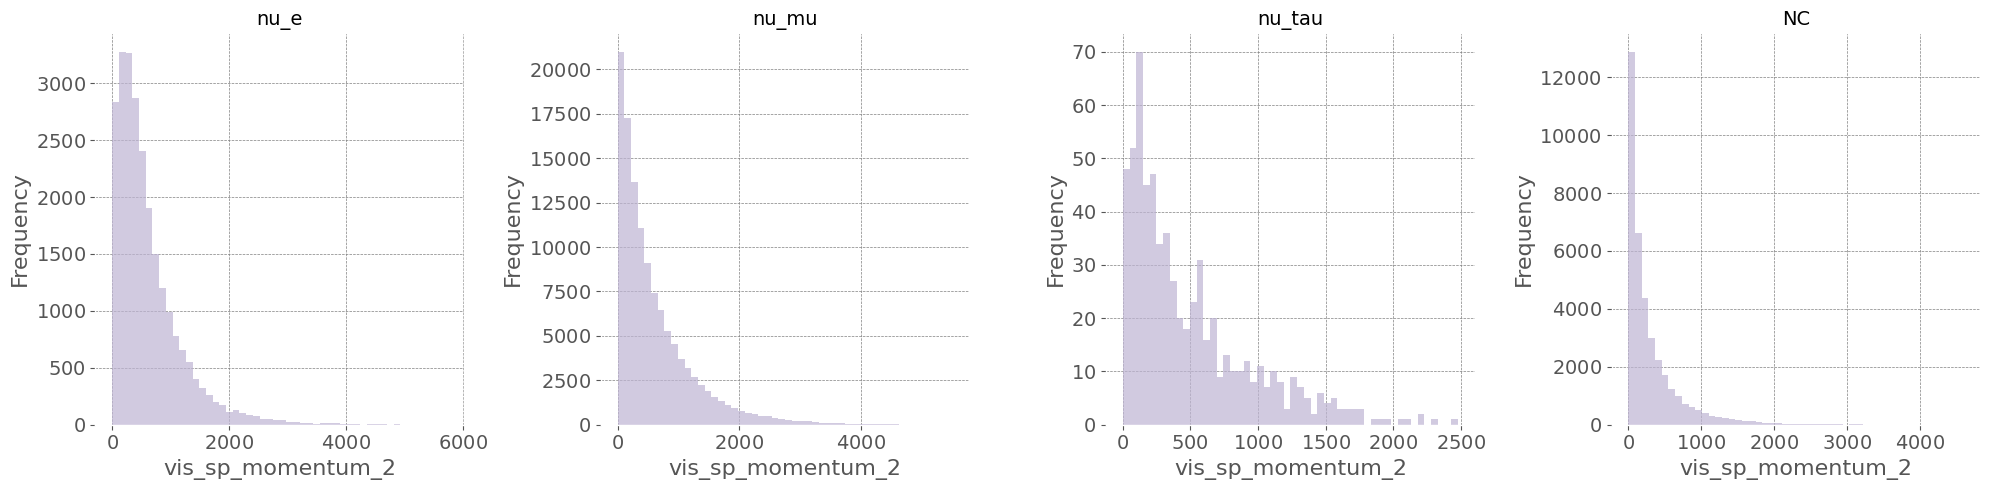

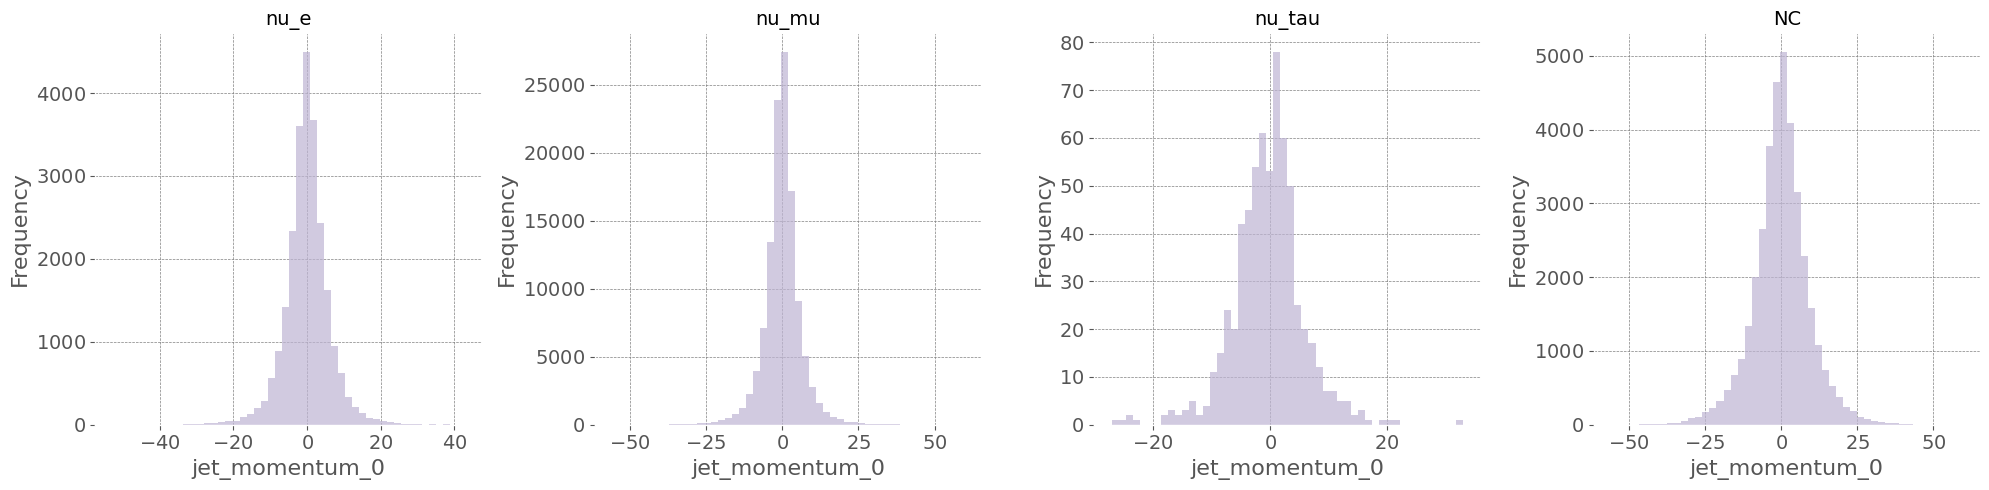

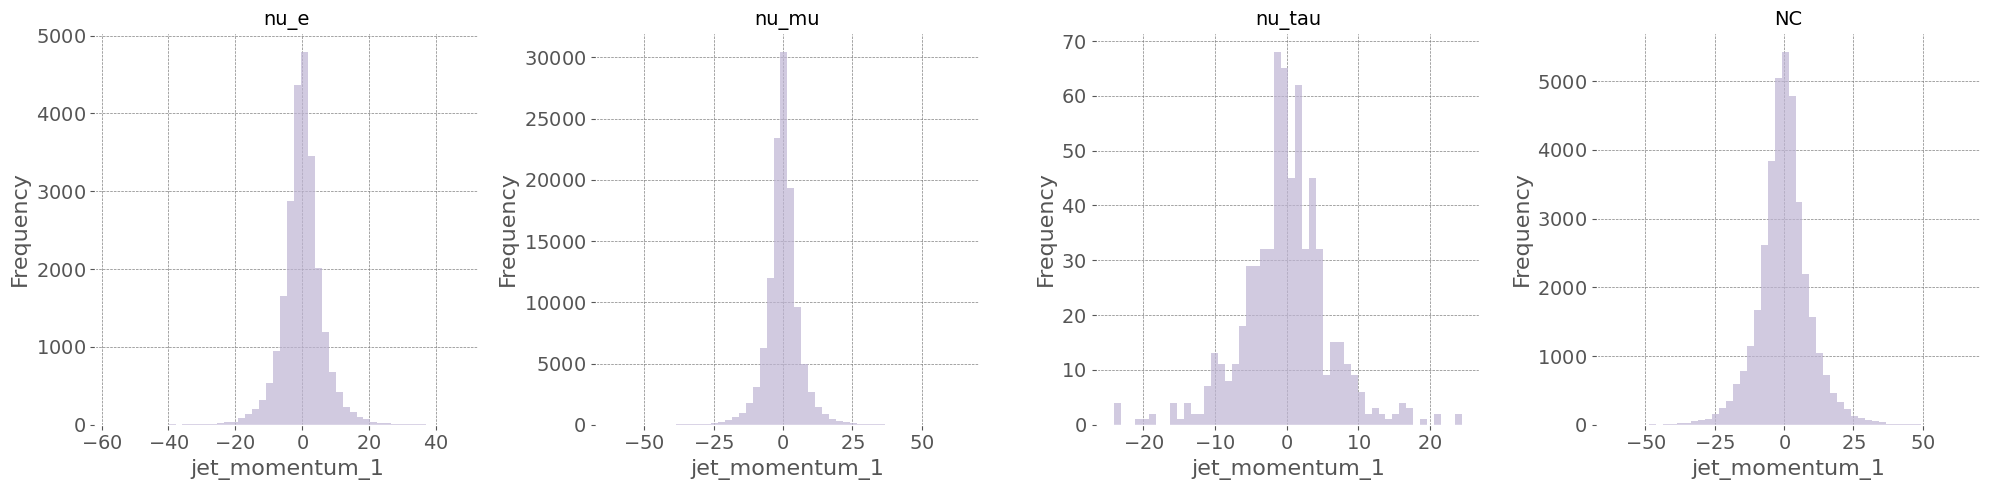

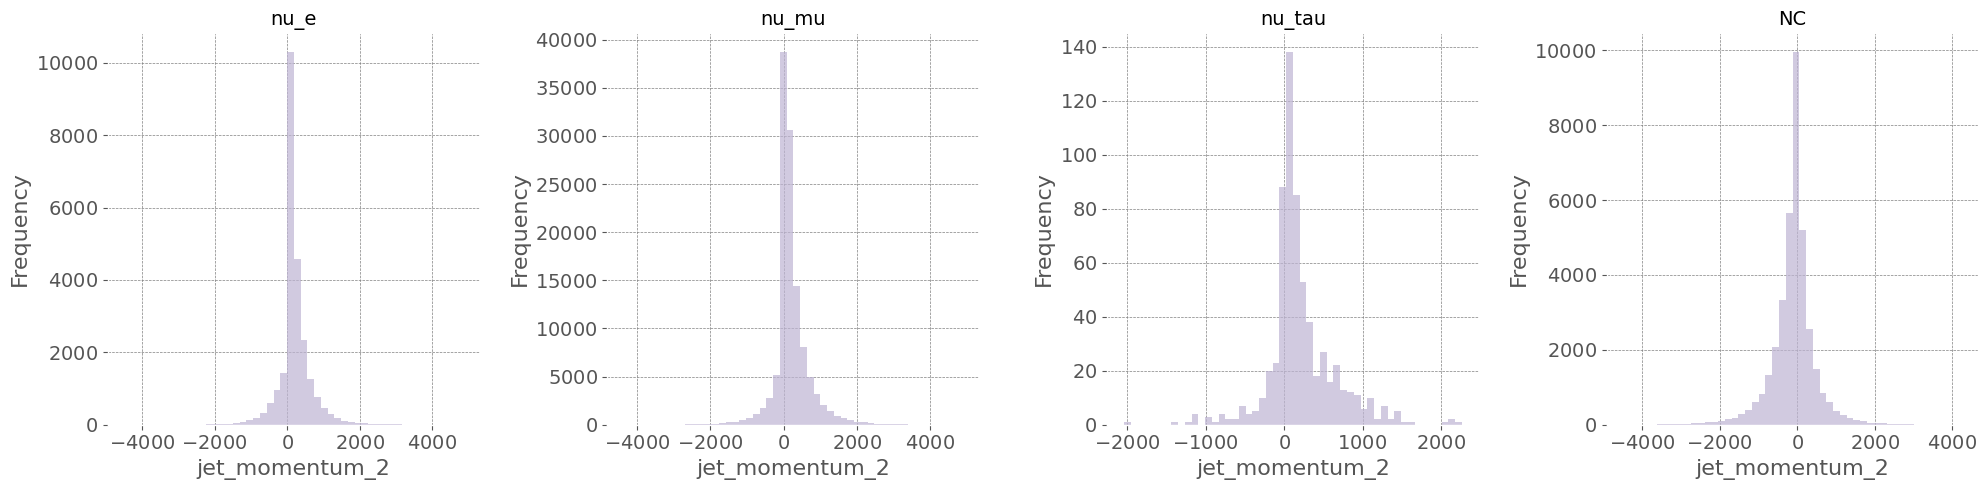

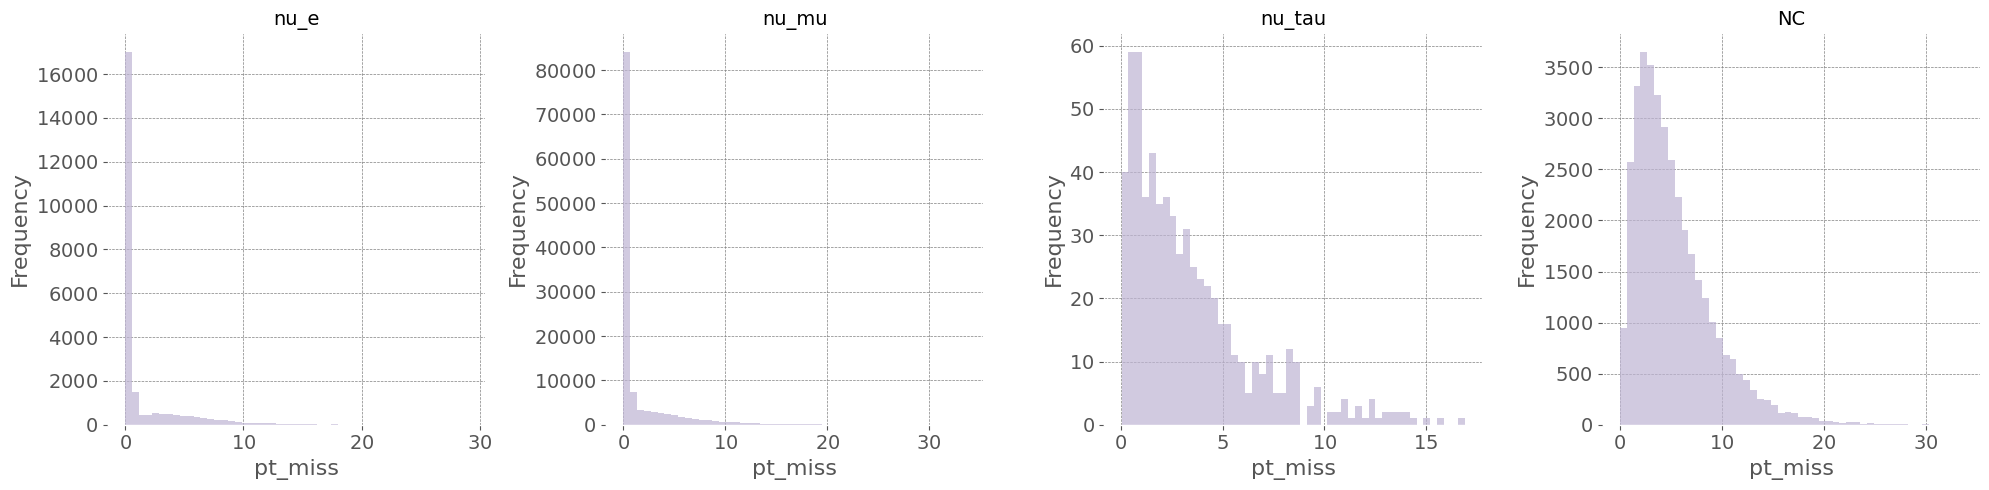

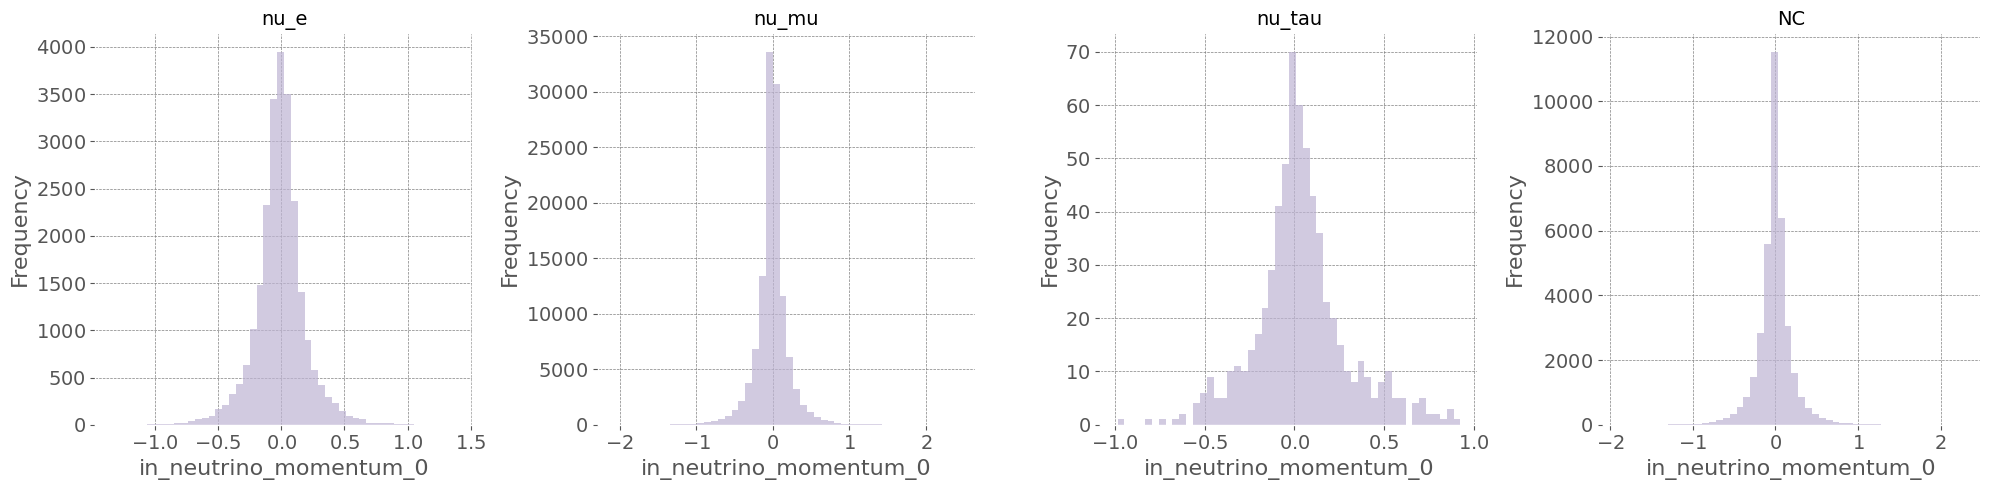

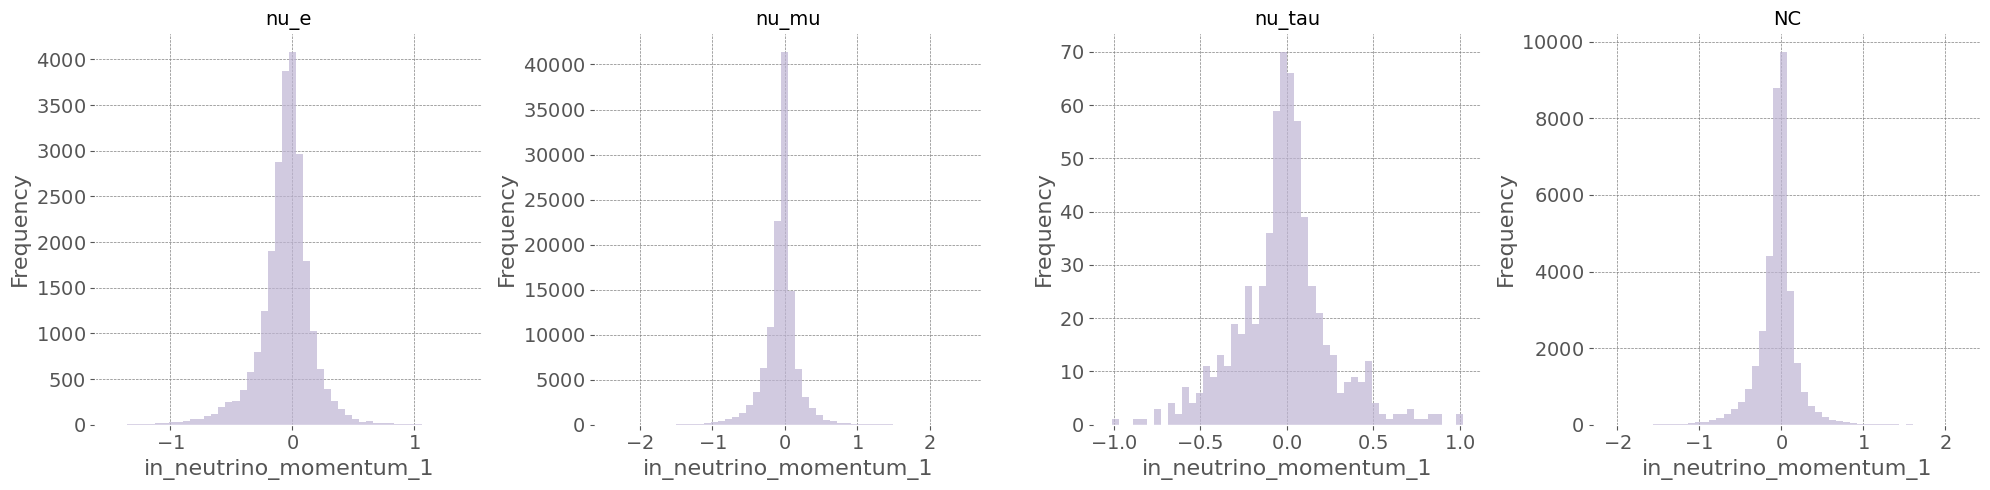

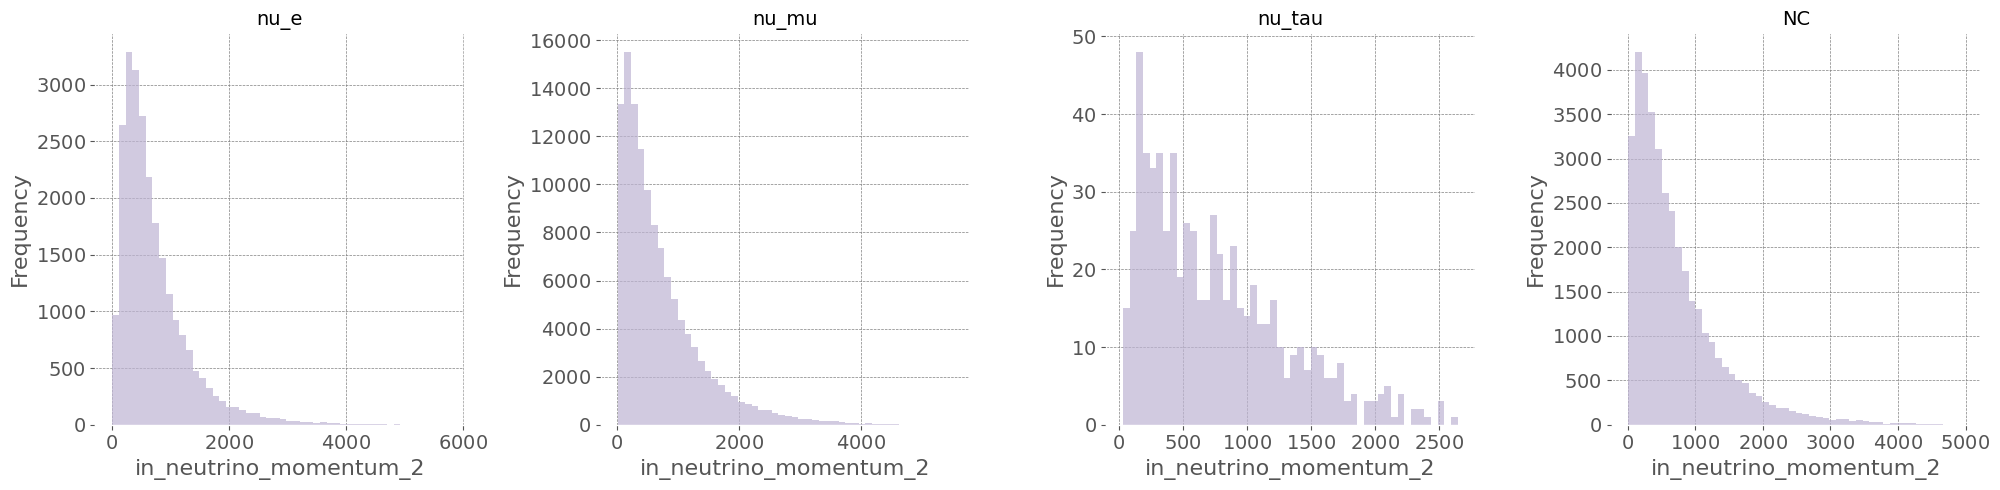

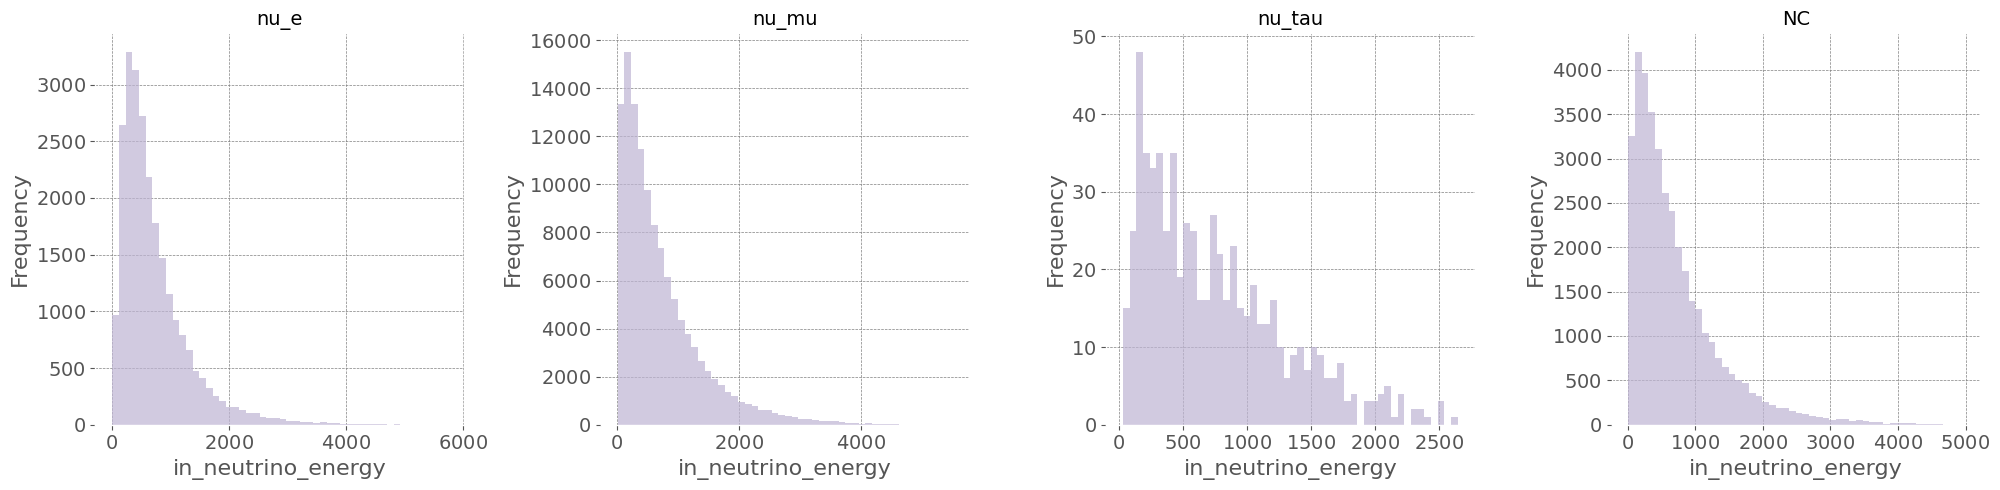

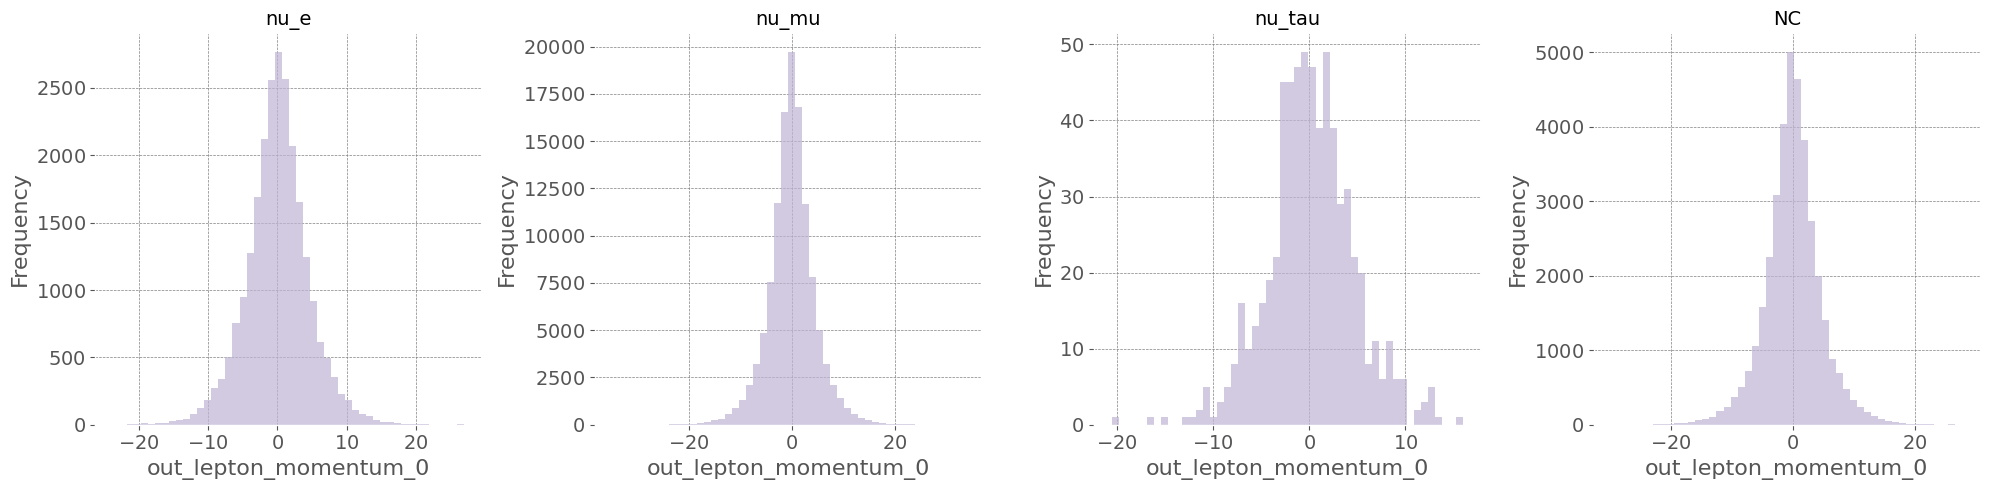

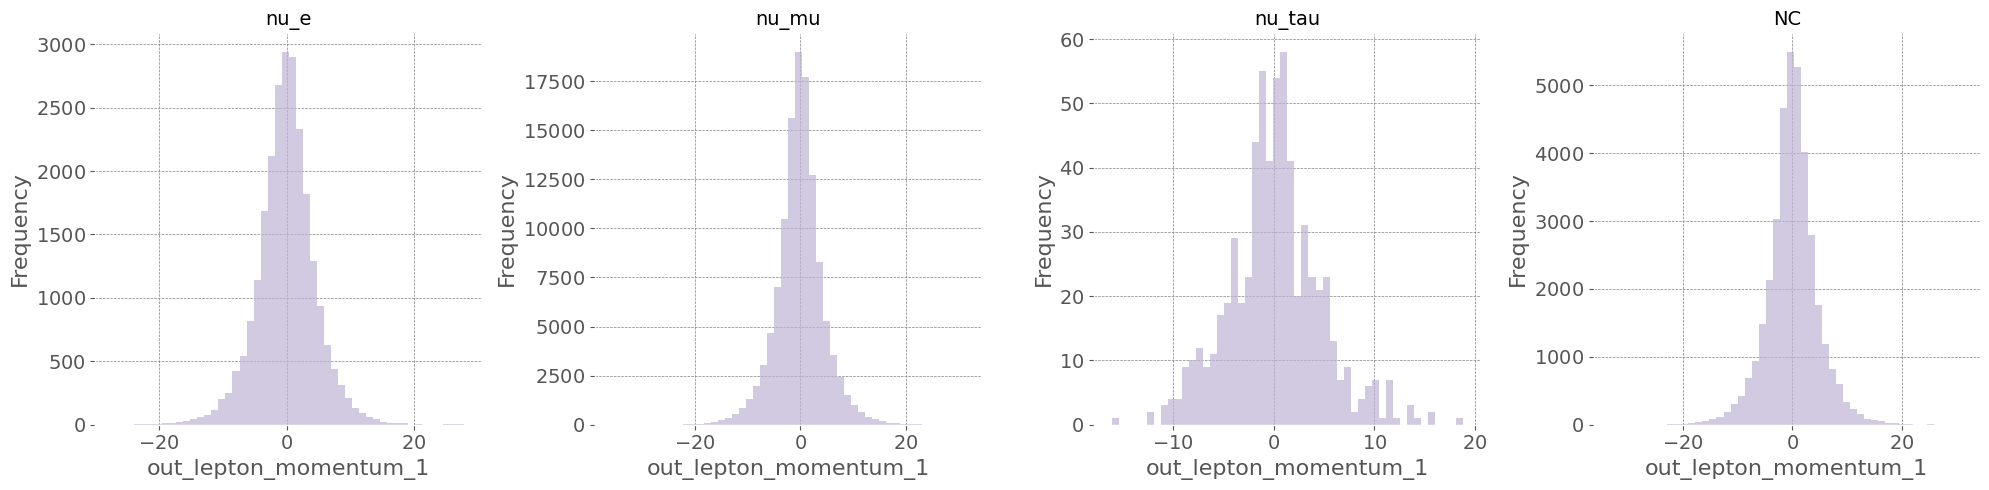

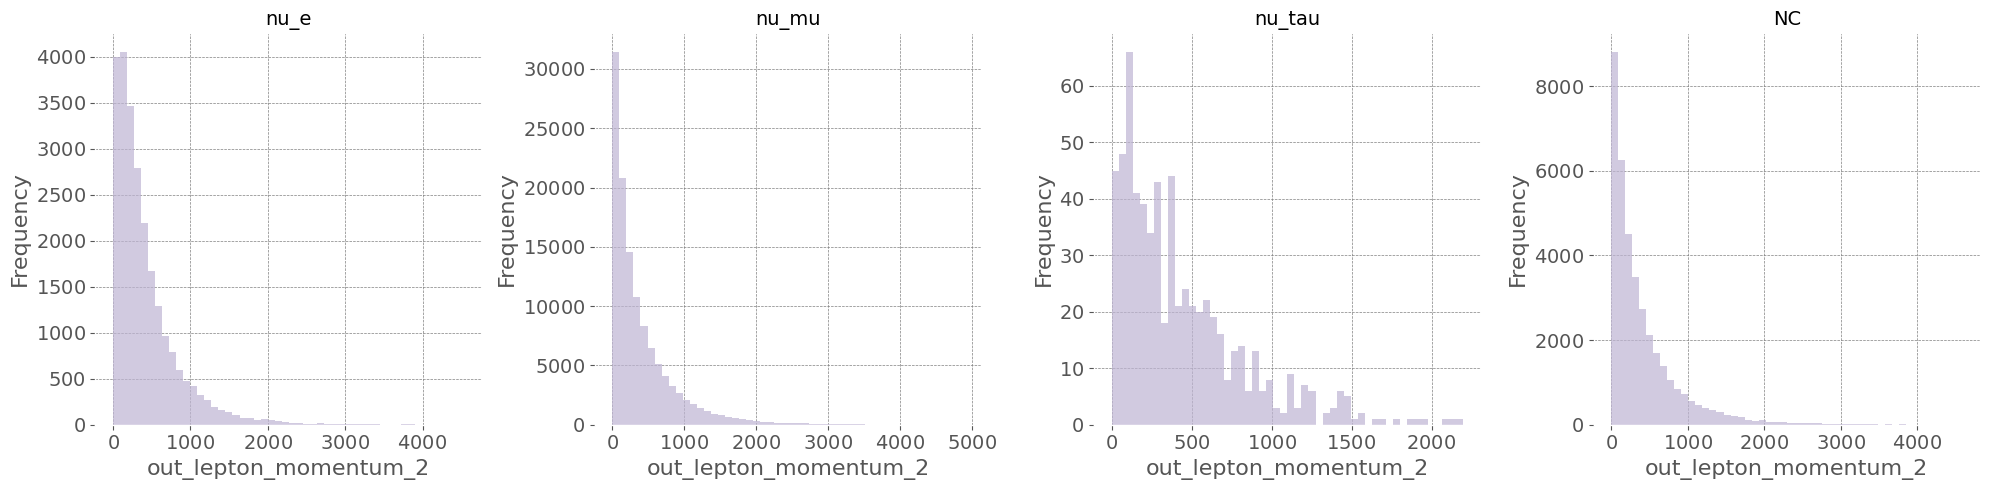

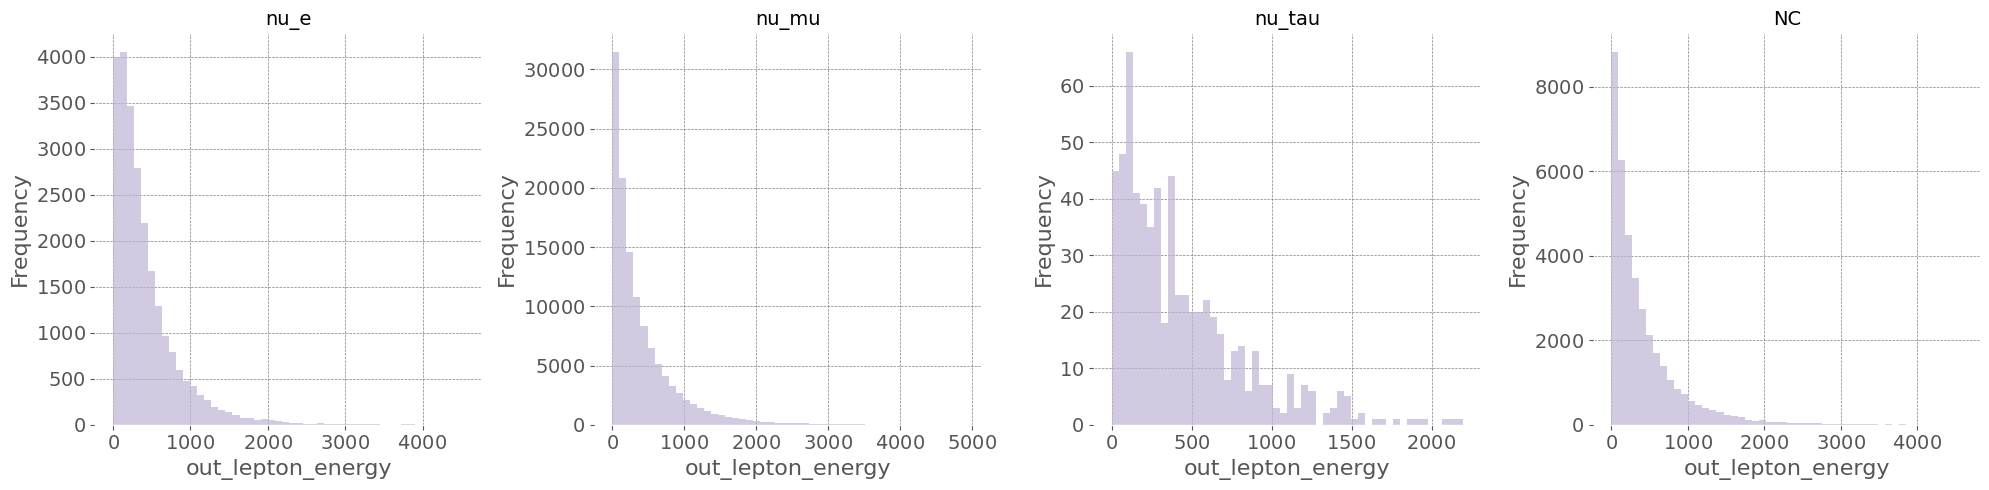

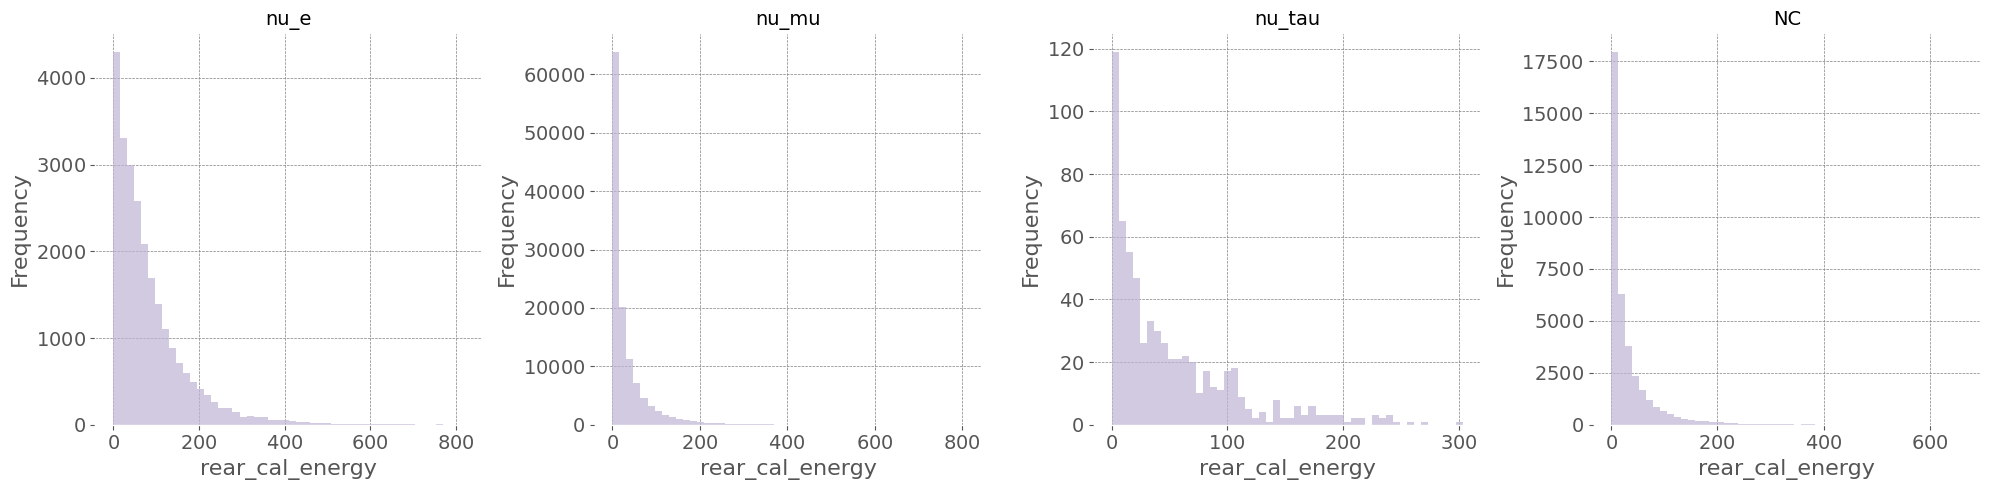

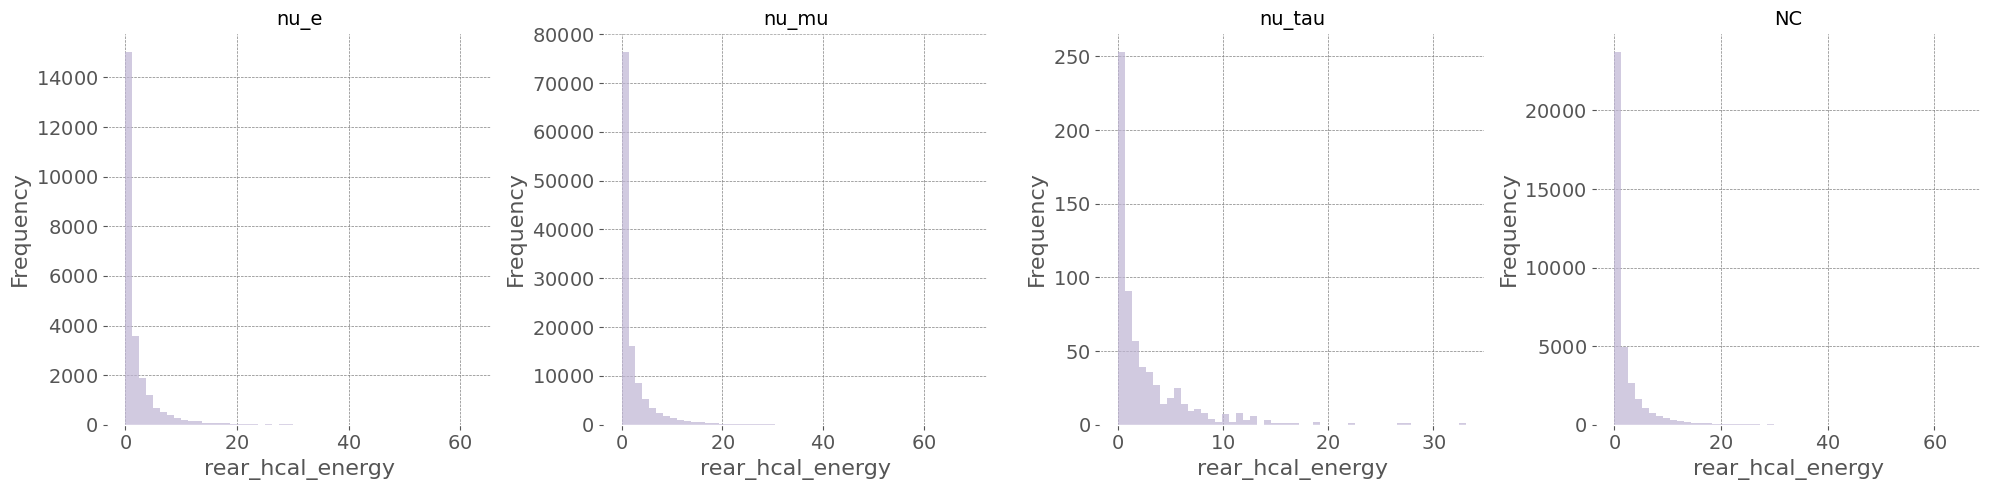

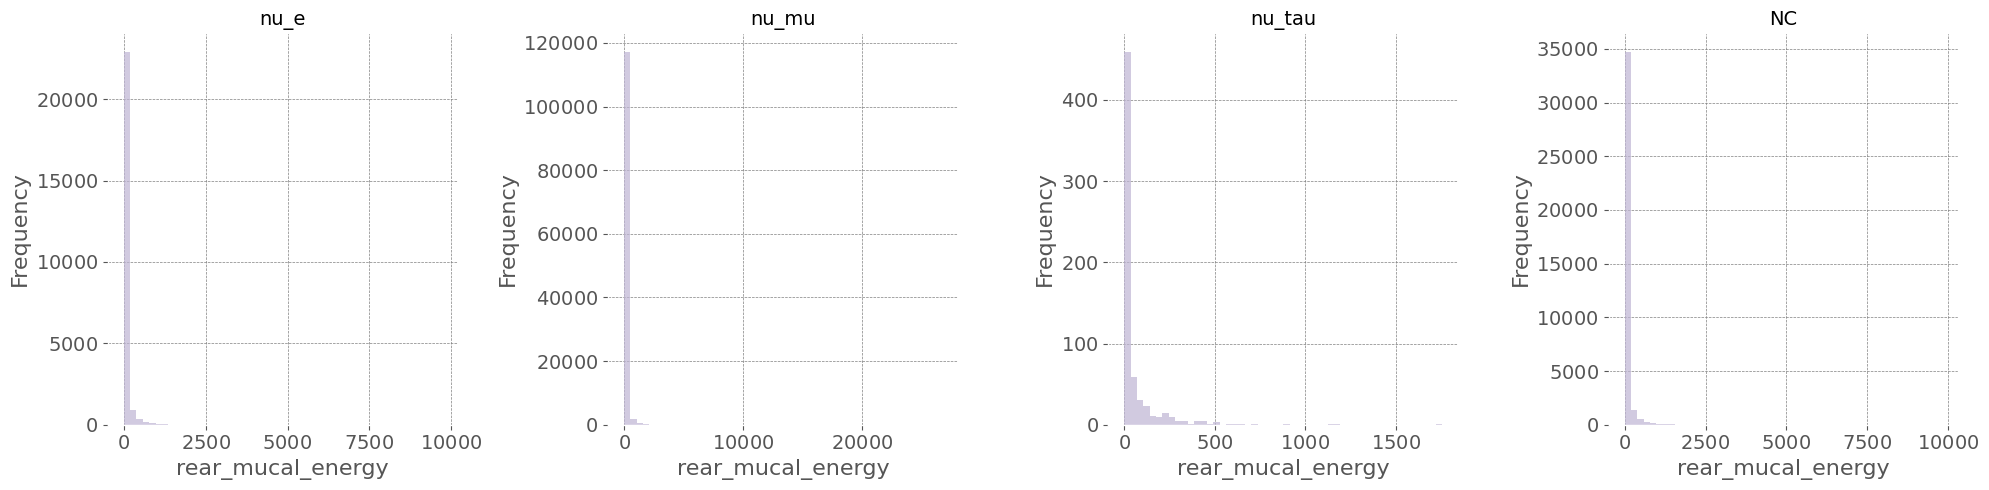

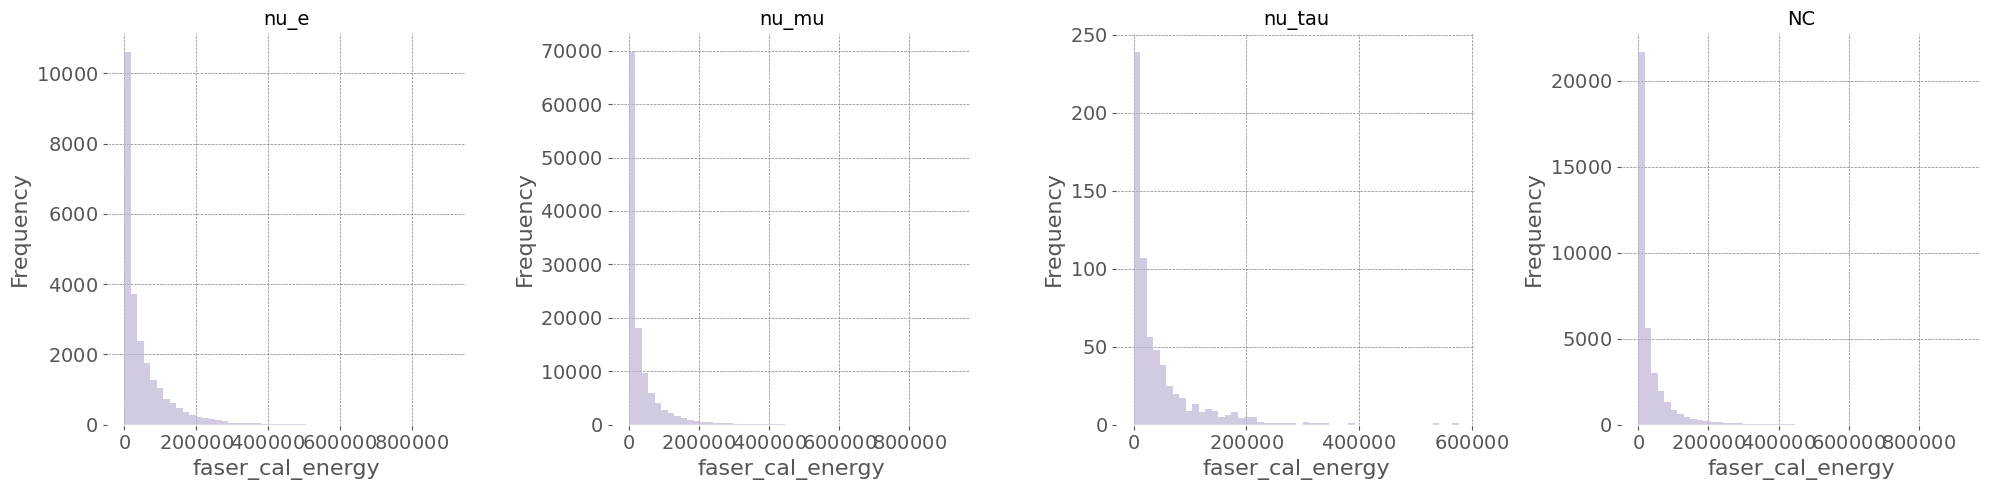

In [ ]:
# Example usage to plot 'e_vis'
for feat in feat_plot:
    plot_histograms(data_nu_e, data_nu_mu, data_nu_tau, data_nc, feat, bins=50, figsize=(20, 5))

# RECO HITS

In [ ]:
#now the reco_hits
# Load the data
variables_to_extract = ['reco_hits','is_cc', 'in_neutrino_pdg']
data_dict = load_variables_from_npz(folder_path, variables_to_extract)

Processing files: 100%|██████████| 10000/10000 [00:07<00:00, 1260.78it/s]


In [ ]:
data_dict["reco_hits"] = np.vstack(data_dict["reco_hits"])[:N_EVENTS]

In [ ]:
#DIVIDE THE DATA INTO THE DIFFERENT INTERACTIONS
is_cc = data_dict['is_cc'].astype(bool)  # Convert to boolean array
in_neutrino_pdg = data_dict['in_neutrino_pdg'].astype(int)  # Convert to int array

# Define masks for event selection
mask_nc = ~is_cc  # NC events (is_cc is False)
mask_cc_e = is_cc & np.isin(in_neutrino_pdg, [12, -12])  # CC with ν_e / ν̅_e
mask_cc_mu = is_cc & np.isin(in_neutrino_pdg, [14, -14])  # CC with ν_μ / ν̅_μ
mask_cc_tau = is_cc & np.isin(in_neutrino_pdg, [16, -16])  # CC with ν_τ / ν̅_τ

#save into different variables
data_nc = {var: values[mask_nc] for var, values in data_dict.items()}
data_cc_e = {var: values[mask_cc_e] for var, values in data_dict.items()}
data_cc_mu = {var: values[mask_cc_mu] for var, values in data_dict.items()}
data_cc_tau = {var: values[mask_cc_tau] for var, values in data_dict.items()}

reco_hits (2564, 6)
is_cc (2564,)
in_neutrino_pdg (2564,)


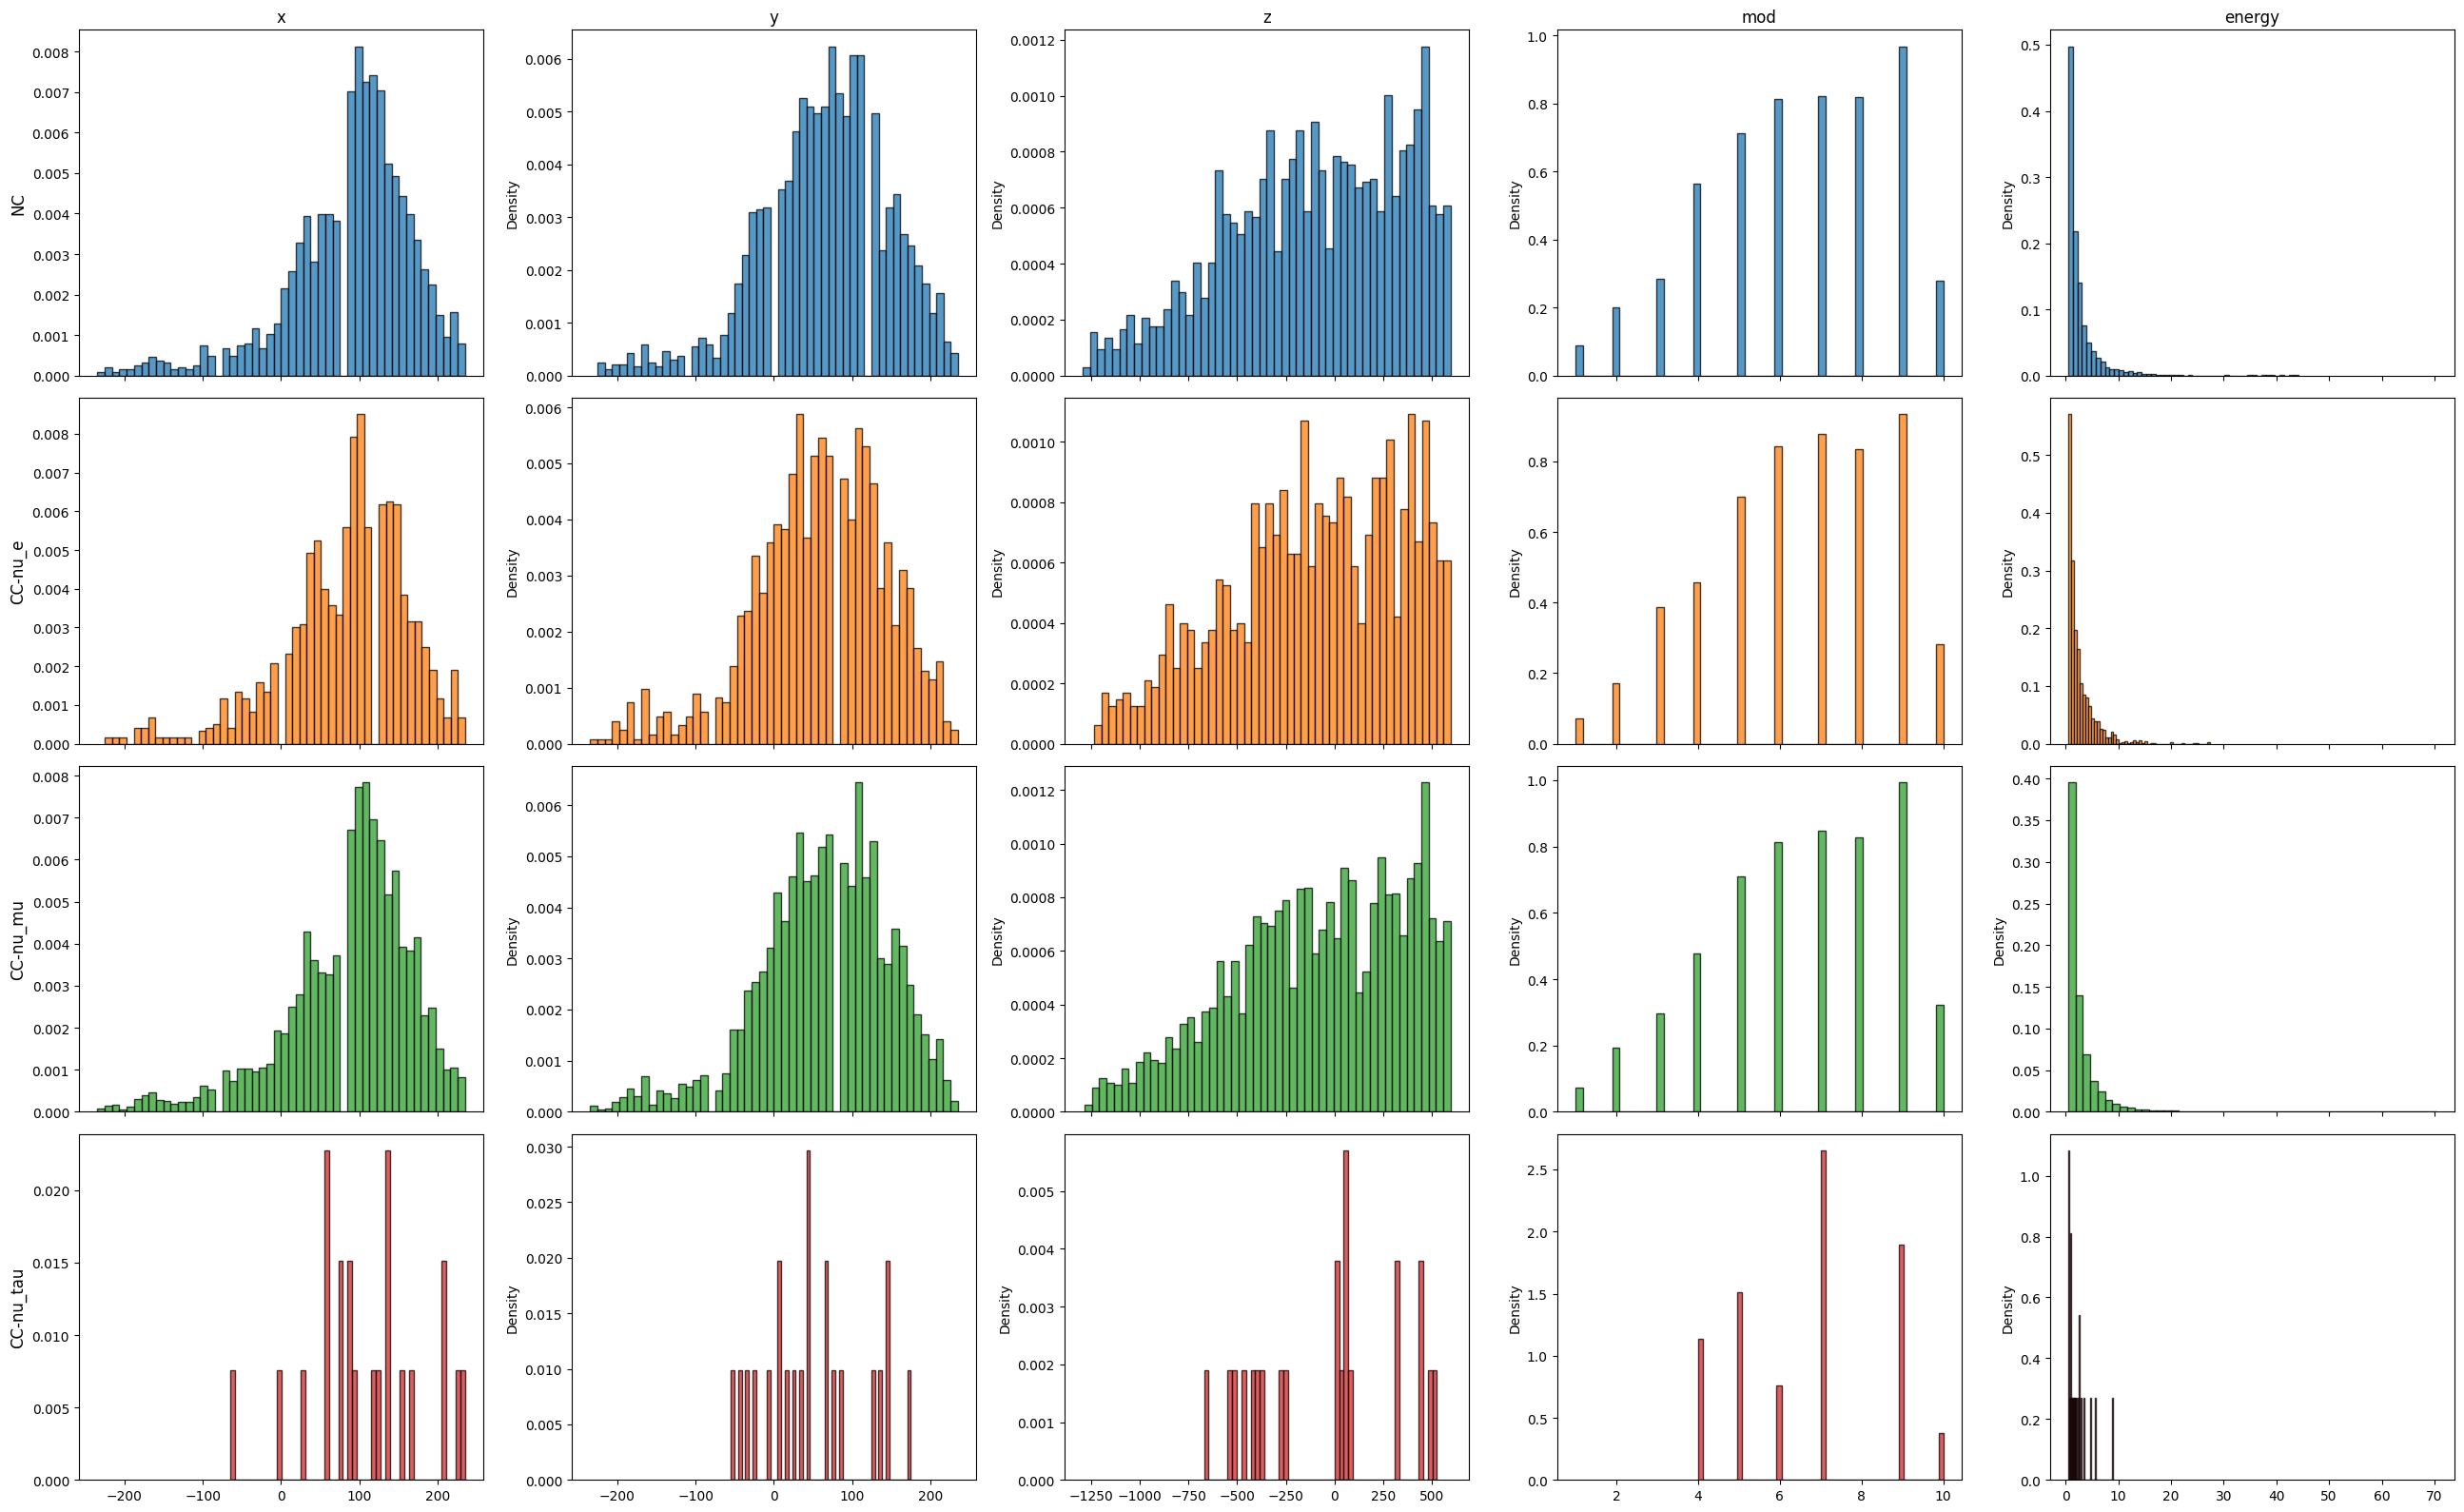

In [ ]:
#do the plot as before per interaction and per variable of the reco_hits

for key in data_nc.keys():
    print(key, data_nc[key].shape)

# Get the variable names (assuming all files have the same variables)
variables = ['x', 'y', 'z','mod', 'energy']

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(26, 16), sharex='col')

# Titles for each row
row_titles = ["NC", "CC-nu_e", 
              "CC-nu_mu", "CC-nu_tau"]

# Plot the data
for col, var in enumerate(variables):
    # Define subplot for each interaction type
    for row, (data, title) in enumerate(zip([data_nc, data_cc_e, data_cc_mu, data_cc_tau], row_titles)):
        ax = axes[row, col] if len(variables) > 1 else axes[row]  # Handle single-variable case
        ax.hist(data["reco_hits"][:, col].flatten(), bins=50, alpha=0.75, color='C'+str(row), edgecolor='black', density=True)
        ax.set_ylabel("Density")
        if row == 0:
            ax.set_title(var, fontsize=12)
        if col == 0:
            ax.set_ylabel(title, fontsize=12)

# Adjust layout
plt.tight_layout()
plt.savefig('histograms_hits.png')
plt.show()